## Here you will find an example when a very simple dataset can't be separeted with ML algorithms without any feature engineering, but meanwhile you will find that the dataset itself is extremely easy

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

At first just have a look at the structure:

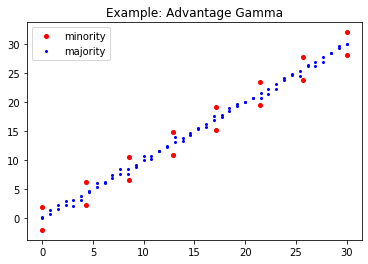

In [3]:
#Create the minority points
x_min = np.linspace(0, 30, 8)
y1_min = x_min+2
y2_min = x_min-2
X_min = np.hstack([x_min, x_min])
Y_min = np.hstack([y1_min, y2_min])
minority = np.concatenate([X_min[np.newaxis, :], Y_min[np.newaxis, :]], axis=0).T

#Create the majority points
x_max = np.linspace(0,30, 40)
y1_max = x_max
y2_max = y1_max + (np.random.rand(40)-0.5)*2
X_max = np.hstack([x_max, x_max])
Y_max = np.hstack([y1_max, y2_max])
majority = np.concatenate([X_max[np.newaxis, :], Y_max[np.newaxis, :]], axis=0).T

x = np.concatenate([minority, majority], axis=0)
y = np.array([1] * 2 * 8 + [0] * 2 * 40)
assert x.shape[0] == len(y)

#Plot the points
plt.plot(X_min, Y_min, 'ro', ms=4, label='minority')
plt.plot(X_max, Y_max, 'bo', ms=2, label='majority')
plt.title('Example: Advantage Gamma')
plt.legend()
plt.show()

Now we create a function which generates a dataset with the same structure as dataset above

In [0]:
def generate_synthetic_dataset():
    # Create the minority points
    n_minority = 250
    x_min = np.linspace(0, 1000, n_minority)
    y1_min = x_min + 2
    y2_min = x_min - 2
    X_min = np.hstack([x_min, x_min])
    Y_min = np.hstack([y1_min, y2_min])
    minority = np.concatenate([X_min[np.newaxis, :], Y_min[np.newaxis, :]], axis=0).T

    # Create the majority points
    n_majority = 2500
    x_max = np.linspace(0, 1000, n_majority)
    y1_max = x_max
    y2_max = y1_max + (np.random.rand(n_majority) - 0.5) * 2
    X_max = np.hstack([x_max, x_max])
    Y_max = np.hstack([y1_max, y2_max])
    majority = np.concatenate([X_max[np.newaxis, :], Y_max[np.newaxis, :]], axis=0).T

    x = np.concatenate([minority, majority], axis=0)
    y = np.array([1] * 2 * n_minority + [0] * 2 * n_majority)
    assert x.shape[0] == len(y)

    #Plot the points
    plt.plot(X_min, Y_min, 'ro', ms=4, label='minority')
    plt.plot(X_max, Y_max, 'bo', ms=2, label='majority')
    plt.title('Example: Advantage Gamma')
    plt.legend()
    plt.show()

    return x, y

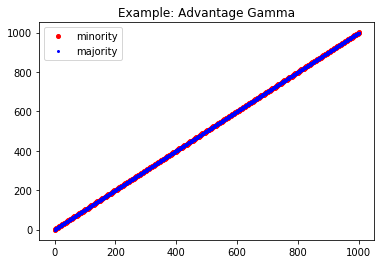

In [5]:
# get our dataset
x, y = generate_synthetic_dataset()

In [6]:
x = pd.DataFrame(x)
x

,0,1
0,0.000000,2.000000
1,4.016064,6.016064
2,8.032129,10.032129
3,12.048193,14.048193
4,16.064257,18.064257
...,...,...
5495,998.399360,999.094208
5496,998.799520,998.987651
5497,999.199680,998.591371
5498,999.599840,998.754317


Now usual process - fit&predict:

### 1. RF:

In [7]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

clf = RandomForestClassifier(n_estimators=20)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(f1_score(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))

0.0
0.0
0.0


In [8]:
print(f1_score(y_train, clf.predict(X_train)))
print(precision_score(y_train, clf.predict(X_train)))
print(recall_score(y_train, clf.predict(X_train)))

0.9884169884169884
1.0
0.9770992366412213


### 2. XGB:

In [9]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

clf = XGBClassifier(n_estimators=200)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(f1_score(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))

0.0
0.0
0.0


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 3. NN:

In [10]:
from keras import backend as K


def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))


Using TensorFlow backend.


In [11]:
from keras import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(32, activation='relu', input_dim=x.shape[1]))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', f1])
# model.fit(X, y, epochs=100, verbose=0)
model.fit(X_train, y_train, epochs=50, verbose=2)






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/50





 - 0s - loss: 0.6427 - acc: 0.9005 - f1: 0.0061
Epoch 2/50
 - 0s - loss: 0.4712 - acc: 0.8993 - f1: 0.0027
Epoch 3/50
 - 0s - loss: 0.4076 - acc: 0.9043 - f1: 0.0014
Epoch 4/50
 - 0s - loss: 0.4277 - acc: 0.8980 - f1: 0.0030
Epoch 5/50
 - 0s - loss: 0.3796 - acc: 0.9009 - f1: 0.0013
Epoch 6/50
 - 0s - loss: 0.3717 - acc: 0.9045 - f1: 0.0047
Epoch 7/50
 - 0s - loss: 0.4021 - acc: 0.9002 - f1: 0.0015
Epoch 8/50
 - 0s - loss: 0.3677 - acc: 0.9016 - f1: 0.0019
Epoch 9/50
 - 0s - loss: 0.4381 - acc: 0.8973 - f1: 0.0092
Epoch 10/50
 - 0s - loss: 0.3553 - acc: 0.9050 - f1: 0.0028
Epoch 11/50
 - 0s - loss: 0.3913 - acc: 0.8993 - f1: 0.0043
Epoch 12/50
 - 0s - loss: 0.3718 - acc: 0.9050 - f1: 0.0074
Epoch 13/50
 - 0s - loss: 0.3862 - acc: 0.9025 - f1: 0.0079
Epoch 14/50
 - 0s - loss: 0.3762 - acc: 0.9027 - f1: 0.0036
Epoch 15/50
 - 0s - loss: 0.3579 - acc: 0.9059 - f1: 0.0034
Ep

In [12]:
print(f1_score(y_test, np.around(model.predict(X_test))))
print(precision_score(y_test, np.around(model.predict(X_test))))
print(recall_score(y_test, np.around(model.predict(X_test))))

print(f1_score(y_train, np.around(model.predict(X_train))))
print(precision_score(y_train, np.around(model.predict(X_train))))
print(recall_score(y_train, np.around(model.predict(X_train))))

0.0
0.0
0.0
0.004914004914004914
1.0
0.0024630541871921183


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 4. LogReg:

In [13]:
clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(f1_score(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))

print(f1_score(y_train, clf.predict(X_train)))
print(precision_score(y_train, clf.predict(X_train)))
print(recall_score(y_train, clf.predict(X_train)))

0.0
0.0
0.0
0.0
0.0
0.0


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## So far each algorithm gave us about 0 on test and even train datasets. But now we will add a feature, so let's see how our algorithms will train

In [14]:
x = pd.DataFrame(x)
x['diff'] = x[1] - x[0] # feature engeni
x = x[[0, 'diff']] # we even remove one feature
x

,0,diff
0,0.000000,2.000000
1,4.016064,2.000000
2,8.032129,2.000000
3,12.048193,2.000000
4,16.064257,2.000000
...,...,...
5495,998.399360,0.694848
5496,998.799520,0.188131
5497,999.199680,-0.608309
5498,999.599840,-0.845522


### Let's draw our current dataset:

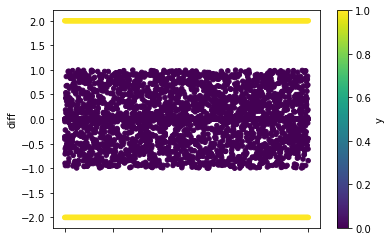

In [15]:
x_temp = x.copy()
x_temp['y'] = y
ax2 = x_temp.plot.scatter(x=0,
                     y='diff',
                     c = 'y',
                      colormap='viridis')

In [16]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

clf = RandomForestClassifier(n_estimators=20)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(f1_score(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))

0.9907407407407407
0.981651376146789
1.0


In [17]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

clf = XGBClassifier(n_estimators=200)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(f1_score(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))

1.0
1.0
1.0


In [18]:
from keras import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(32, activation='relu', input_dim=x.shape[1]))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', f1])
# model.fit(X, y, epochs=100, verbose=0)
model.fit(X_train, y_train, epochs=50, verbose=0)

In [19]:
print(f1_score(y_test, np.around(model.predict(X_test))))
print(precision_score(y_test, np.around(model.predict(X_test))))
print(recall_score(y_test, np.around(model.predict(X_test))))

print(f1_score(y_train, np.around(model.predict(X_train))))
print(precision_score(y_train, np.around(model.predict(X_train))))
print(recall_score(y_train, np.around(model.predict(X_train))))

1.0
1.0
1.0
1.0
1.0
1.0


So now every algorithm gives about 1 precision, recall and f1. Let's see what will be the output of Logreg:

In [20]:
clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(f1_score(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))

0.0
0.0
0.0


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Still all metrics are zero. Let's check LogReg for the whole dataset:

In [21]:
clf = LogisticRegression()
clf.fit(x, y)
y_pred = clf.predict(x)

print(f1_score(y, y_pred))
print(precision_score(y, y_pred))
print(recall_score(y, y_pred))

0.0
0.0
0.0


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


And still everything is zero!

Let's look at the coefficients:

In [22]:
print(clf.coef_, clf.intercept_)

[[-1.15613893e-07  6.58960403e-03]] [-2.30251545]


That means that we have decision line:
approximately: $0 \cdot x + 0.061y-2.3=0$

If you draw this line you will see that the whole dataset lines on one side of this line, that's why algorithm predicts everything as 0

Let's check it:

In [0]:
y_pred = clf.predict(x)
assert y_pred.sum() == 0

Let's test LogReg on smaller dataset:

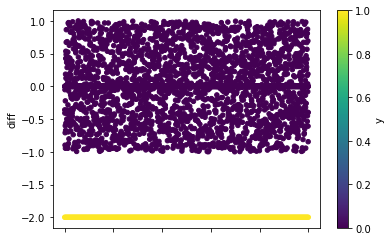

In [24]:
x_temp = x.copy()
x_temp = x_temp[250:]
y_temp = y.copy()[250:]
x_temp['y'] = y_temp
ax3 = x_temp.plot.scatter(x=0,
                     y='diff',
                     c = 'y',
                      colormap='viridis')

In [25]:
clf = LogisticRegression()
clf.fit(x_temp.drop('y', axis=1), y_temp)
y_pred = clf.predict(x_temp.drop('y', axis=1))

print(f1_score(y_temp, y_pred))
print(precision_score(y_temp, y_pred))
print(recall_score(y_temp, y_pred))

1.0
1.0
1.0


Finally it works, let's check the line:

In [26]:
print(clf.coef_, clf.intercept_)

[[ 5.90323783e-05 -7.04282652e+00]] [-10.42855259]


So now our line is about:
$0 \cdot x - 7.05 \cdot y -10.5 = 0$

And if you draw this line you will see that it now it separates clearly minority and majority class